In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
#import cmocean as cm
import seawater as sw
import gsw
import xgcm
from xgcm.autogenerate import generate_grid_ds

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.0:44106 Dashboard: http://10.148.1.0:8787/status,Cluster Workers: 30 Cores: 120 Memory: 1500.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_D,ds_B,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center
Z Axis (not periodic):
  * center   depth (52) --> left
  * left     depth_left (52) --> center


In [7]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

# 2. define perturbation (e.g., u', v')

In [11]:
w_mean = ds.W.mean(['lat','lon'])
b_mean = ds.Buoy.mean(['lat','lon'])
u_mean = ds.U.mean(['lat','lon_g'])
v_mean = ds.V.mean(['lat_g','lon'])

In [12]:
w_prime = ds.W - w_mean
b_prime = ds.Buoy - b_mean
u_prime = ds.U - u_mean
v_prime = ds.V - v_mean

In [13]:
u_prime_ij = gridx.interp(u_prime,'X')
u_prime_ij

<xarray.DataArray 'mul-b24c2fe89967bdc4c564a9f67ed8d364' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [14]:
v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

<xarray.DataArray 'mul-e90162ef0defa7b1ee73a1a7f5953f88' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [15]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-be2b3a161d06f6c6264c0fb189949fae' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [16]:
dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')
print(dV_dz_ij)

<xarray.DataArray 'mul-f4aa6a4eb20ca7f095ee950a0caa54d8' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


# 4. VSP

## 4.1 Method 1

In [17]:
vsp_1 = -1*((w_prime.isel(lon=slice(80,100),lat=slice(90,110)) * u_prime_ij.isel(lon=slice(80,100),lat=slice(90,110))).mean(['lat','lon']) * dU_dz_ij.isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon']) + (w_prime.isel(lon=slice(80,100),lat=slice(90,110)) * v_prime_ij.isel(lon=slice(80,100),lat=slice(90,110))).mean(['lat','lon']) * dV_dz_ij.isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon']))
vsp_1.load()
vsp_1

<xarray.DataArray (time: 9415, depth: 52)>
array([[          nan,  3.158974e-08,  3.137302e-08, ..., -2.171216e-09,
         7.884490e-09,  6.332051e-09],
       [          nan,  3.124339e-08,  3.214311e-08, ...,  5.495217e-09,
         7.343993e-09,  4.799147e-09],
       [          nan,  2.750713e-08,  3.001180e-08, ...,  1.161753e-08,
         1.004439e-08,  5.230676e-09],
       ...,
       [          nan,  1.157166e-09,  5.988246e-09, ...,  4.528842e-10,
         6.709180e-10,  1.265555e-10],
       [          nan,  2.004396e-09,  1.237921e-08, ...,  3.897202e-08,
         3.252638e-08,  1.328106e-08],
       [          nan, -1.247605e-09,  1.505705e-08, ...,  1.062913e-07,
         9.322337e-08,  3.885403e-08]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

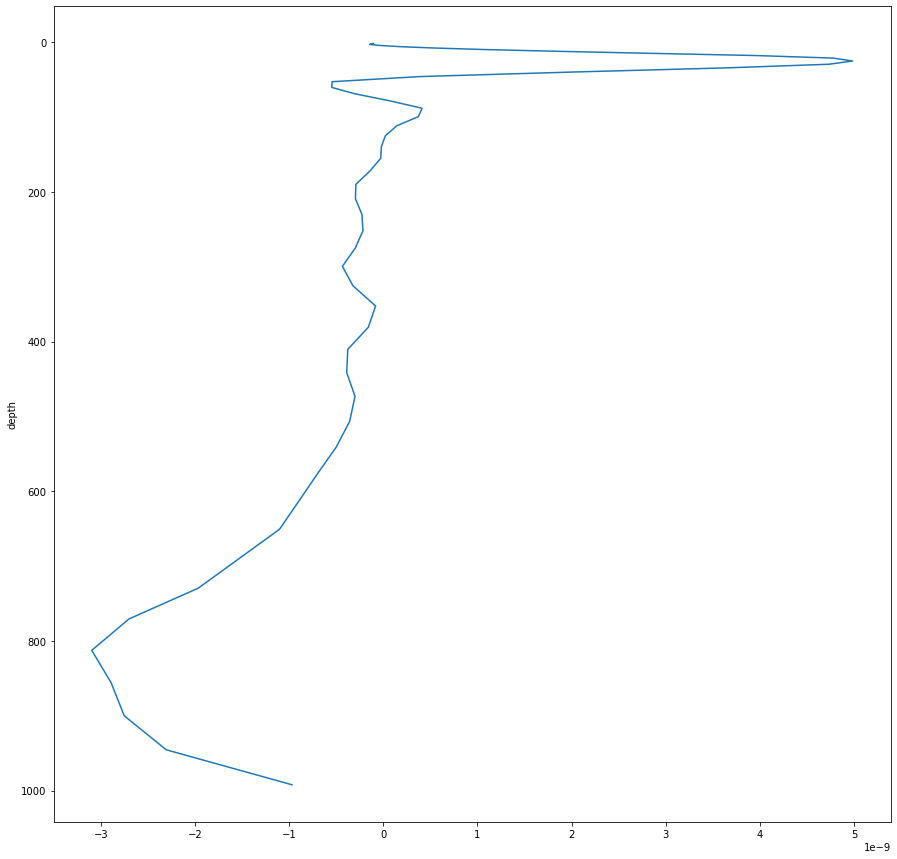

In [18]:
fig = plt.figure(figsize=(15,15))
vsp_1.mean('time').plot(y='depth', yincrease=False)

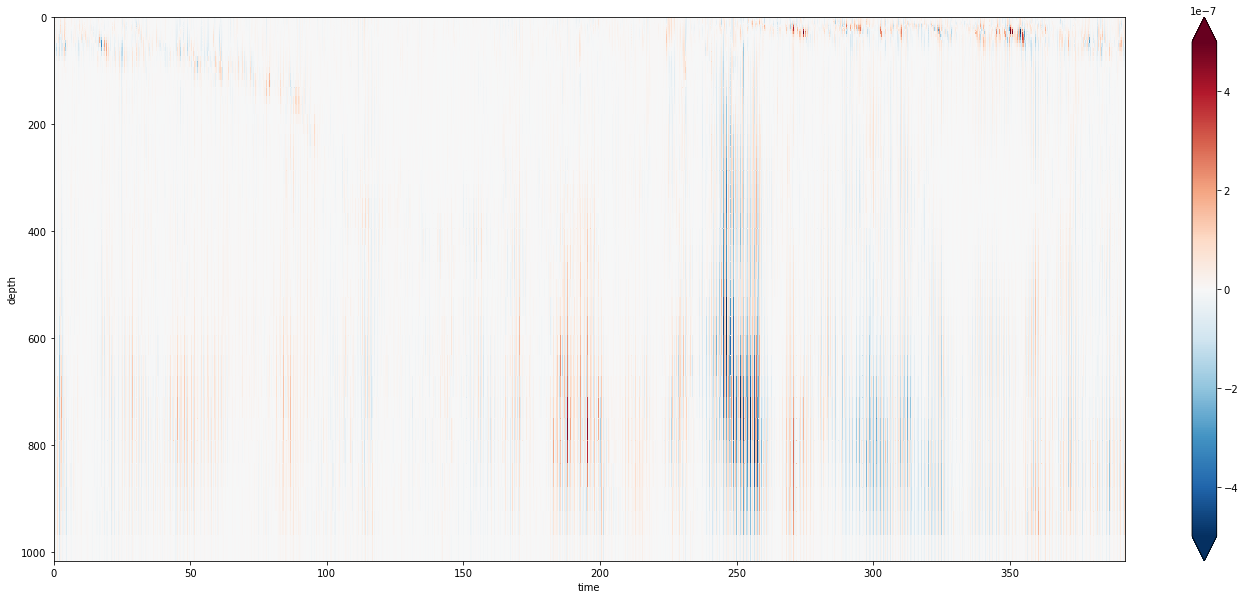

In [20]:
fig = plt.figure(figsize=(24,10))
vsp_1.plot(x='time', y='depth',vmin=-5e-7,vmax=5e-7,cmap='RdBu_r', yincrease=False)

## 4.2 Method 2

In [25]:
vsp_2 = -1*(w_prime * u_prime_ij * dU_dz_ij + w_prime * v_prime_ij * dV_dz_ij)
vsp_2_mean = vsp_2.isel(time=slice(3000,6000),lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon'])
vsp_2_mean.load()
vsp_2_mean

<xarray.DataArray (time: 3000, depth: 52)>
array([[          nan,  9.247625e-10,  1.189868e-09, ..., -1.060058e-08,
        -4.847148e-09,  1.889952e-09],
       [          nan, -2.713467e-10, -5.441345e-11, ...,  7.626476e-09,
         8.101573e-09,  2.946520e-09],
       [          nan, -8.324769e-10, -9.842748e-10, ...,  5.576822e-09,
         1.171255e-08,  5.044251e-09],
       ...,
       [          nan, -9.807471e-10, -2.767501e-09, ...,  8.263954e-08,
         8.716651e-09, -9.131361e-09],
       [          nan,  9.357634e-10, -4.486502e-10, ...,  8.490609e-08,
         2.559539e-08,  6.162442e-09],
       [          nan,  2.137652e-09,  1.388850e-09, ...,  6.861371e-08,
         4.499190e-08,  2.081200e-08]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 125.0 125.0 125.1 125.1 125.2 125.2 125.2 125.3 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

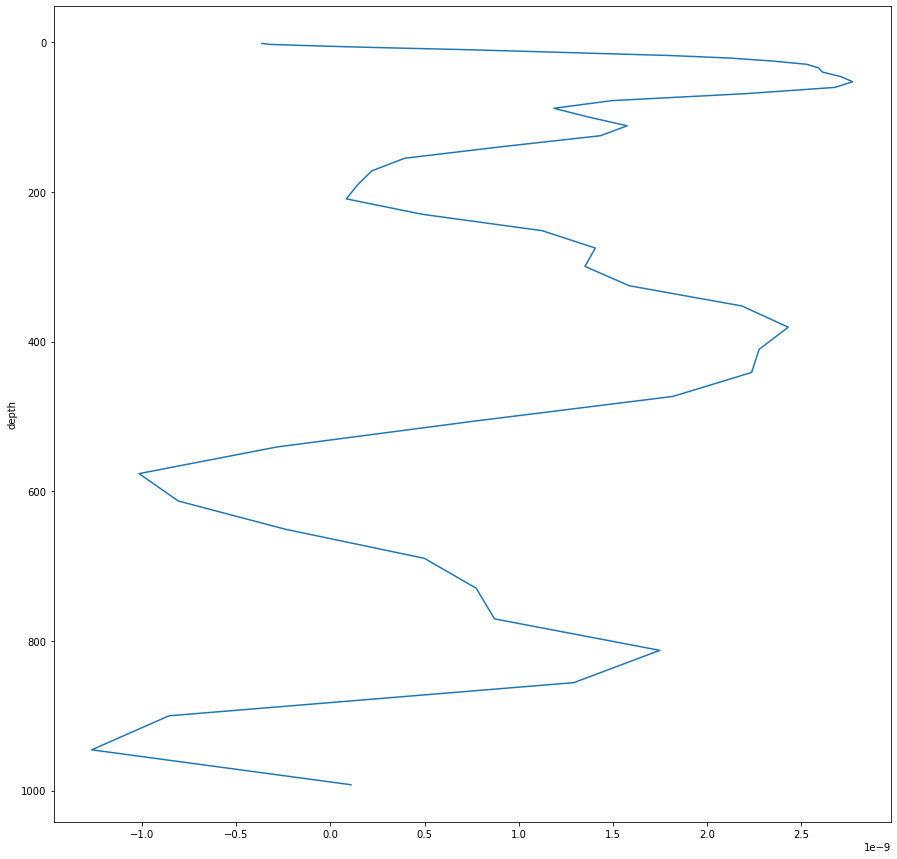

In [26]:
fig = plt.figure(figsize=(15,15))
vsp_2_mean.mean('time').plot(y='depth', yincrease=False)

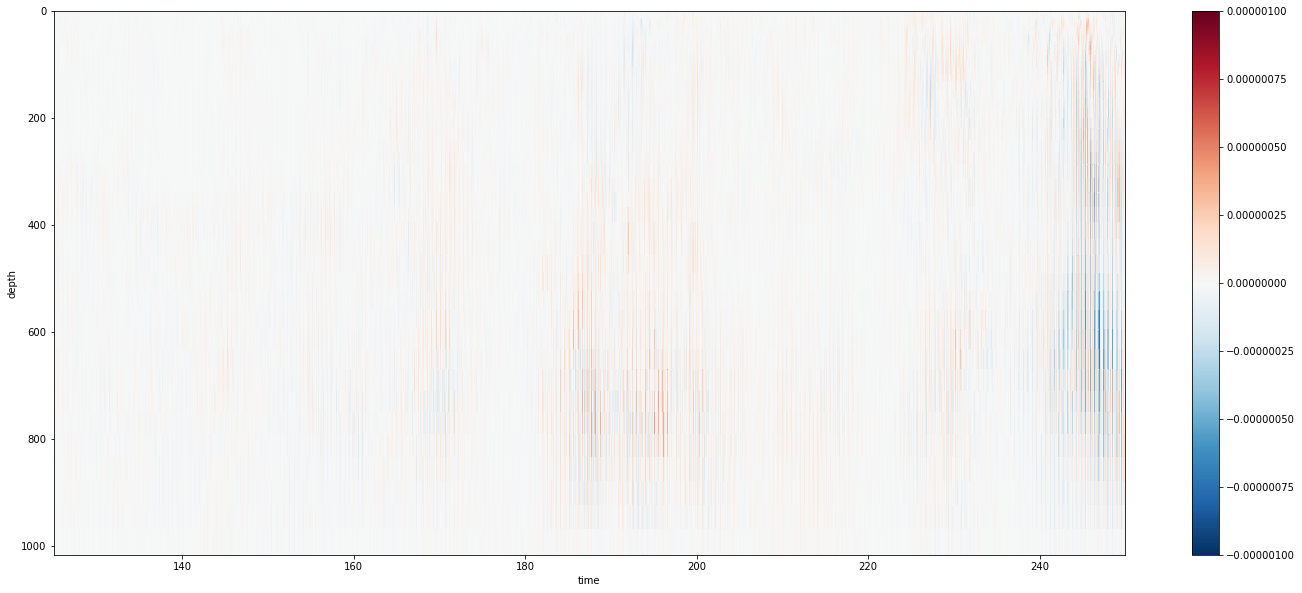

In [28]:
fig = plt.figure(figsize=(24,10))
vsp_2_mean.plot(x='time', y='depth',vmin=-1e-6,vmax=1e-6,cmap='RdBu_r', yincrease=False)

# 5. w'b'

In [29]:
wb_prime = w_prime*b_prime
wb_prime_mean = wb_prime.isel(time=slice(3000,6000),lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon'])
wb_prime_mean

<xarray.DataArray (time: 3000, depth: 52)>
dask.array<shape=(3000, 52), dtype=float32, chunksize=(3000, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 125.0 125.0 125.1 125.1 125.2 125.2 125.2 125.3 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

In [30]:
wb_prime_mean.load()

<xarray.DataArray (time: 3000, depth: 52)>
array([[ 4.205028e-11,  5.753028e-10,  1.173892e-09, ..., -9.222980e-08,
        -6.602377e-08, -3.498990e-08],
       [-5.589416e-11,  6.131278e-10,  1.365030e-09, ...,  3.720549e-07,
         3.241261e-07,  2.984571e-07],
       [-1.483384e-10,  5.011703e-10,  1.233085e-09, ...,  4.696161e-07,
         4.098082e-07,  3.902800e-07],
       ...,
       [ 2.940590e-10, -1.004741e-10, -5.598269e-10, ...,  2.336225e-07,
         2.522318e-07,  2.481426e-07],
       [ 2.925701e-10,  2.982187e-10,  2.923981e-10, ...,  1.647451e-07,
         2.320818e-07,  2.802479e-07],
       [ 2.596282e-10,  6.413406e-10,  1.070932e-09, ...,  2.393468e-07,
         2.401679e-07,  2.590353e-07]], dtype=float32)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 125.0 125.0 125.1 125.1 125.2 125.2 125.2 125.3 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

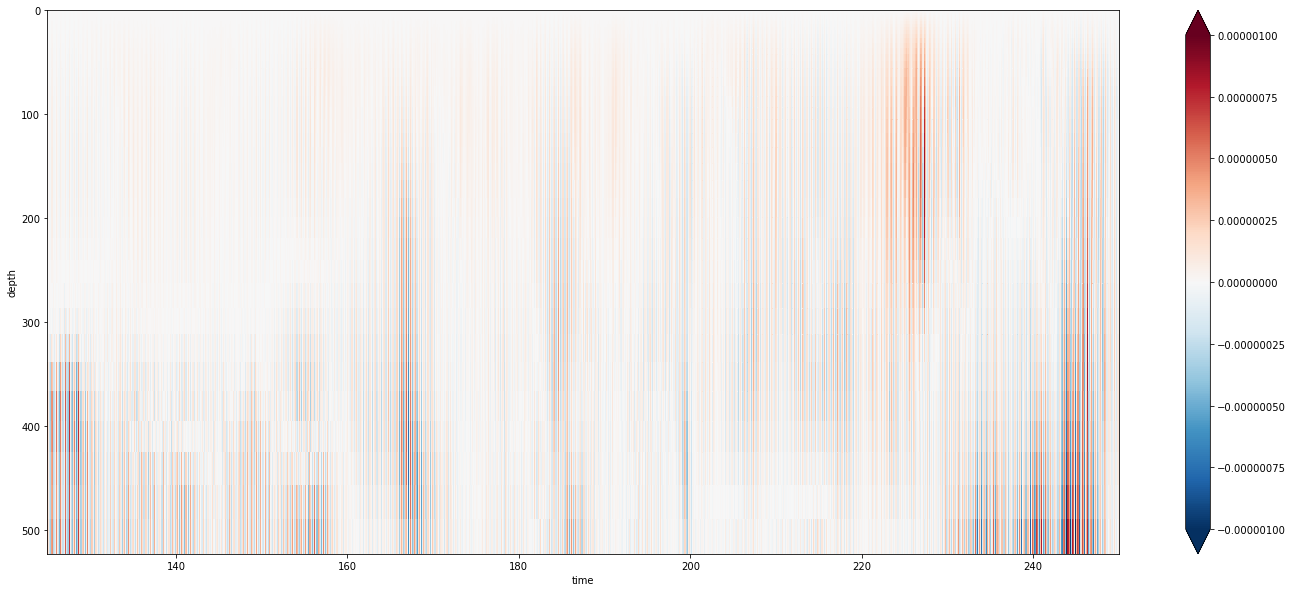

In [32]:
fig = plt.figure(figsize=(24,10))
wb_prime_mean.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-6,vmax=1e-6,cmap='RdBu_r', yincrease=False)

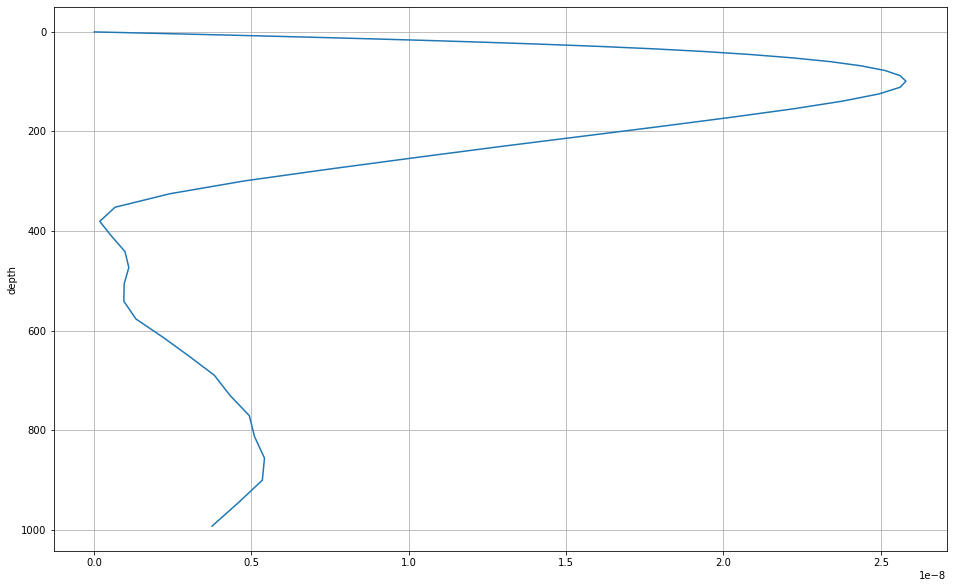

In [33]:
wb_prime_smean = wb_prime_mean.mean('time')
fig, ax = plt.subplots(figsize=(16,10))

wb_prime_smean.plot(y='depth', yincrease=False)
ax.grid()
#vsp.mean('time').plot(y='depth')

# Filter

In [34]:
import xscale

In [35]:
wt = ds.W.window
wt.set()
print(wt)

Window [order->{'time': 9415, 'depth': 52, 'lat': 201, 'lon': 177}, cutoff->{'time': None, 'depth': None, 'lat': None, 'lon': None}, dx->{'time': 0.041666666666666664, 'depth': 1.0699999999999998, 'lat': 0.01320648193359375, 'lon': 0.020833969116210938}, window->{'time': 'boxcar', 'depth': 'boxcar', 'lat': 'boxcar', 'lon': 'boxcar'}]


In [36]:
wt.set(n=20, dim='time', window='boxcar')

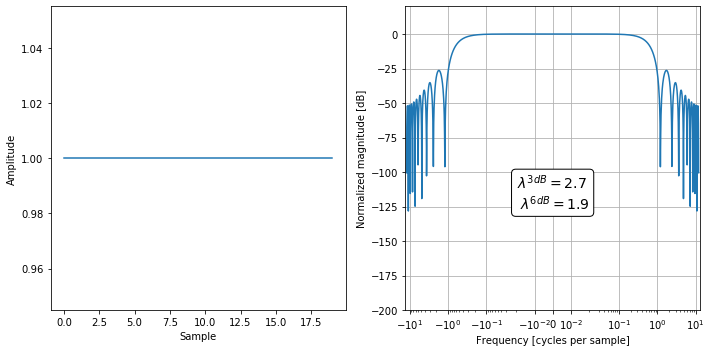

In [37]:
wt.plot()

In [55]:
cutoff_10d = 72 # A 24-hour cutoff
dx_1d = 0.041666666666666664 # Define the sampling period (one day)

wt.set(n=20, dim='time', cutoff=cutoff_10d, dx=dx_1d, window='hanning')

In [56]:
print(wt)

Window [order->{'time': 20}, cutoff->{'time': 72}, dx->{'time': 0.041666666666666664}, window->{'time': 'hanning'}]


In [57]:
res = wt.convolve()

In [58]:
res_valid = wt.convolve(trim=True)

In [59]:
res_valid

<xarray.DataArray 'W' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YC       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    CS       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    SN       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    Depth    (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    rA       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dzt      (depth) f

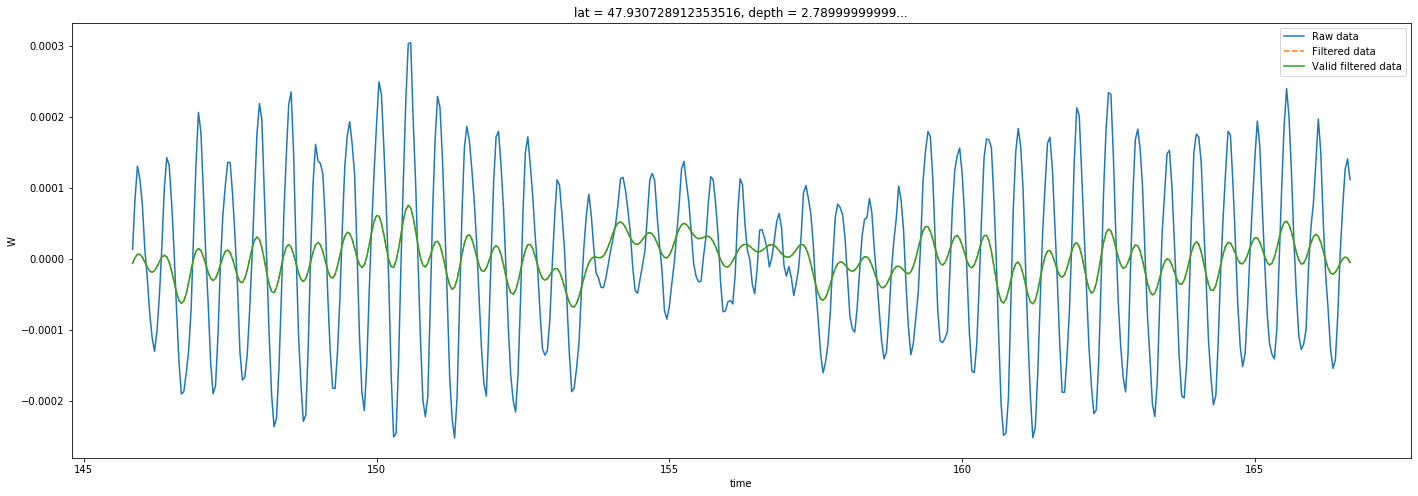

In [60]:
plt.figure(figsize=(24,8))


ds.W.isel(lat=40, lon=40,depth=2,time=slice(3500,4000)).plot(label="Raw data")
res.isel(lat=40, lon=40,depth=2,time=slice(3500,4000)).plot(label="Filtered data", ls="--")
res_valid.isel(lat=40, lon=40,depth=2,time=slice(3500,4000)).plot(label="Valid filtered data")
plt.legend()
plt.show()

In [62]:
cluster.scheduler.close()

<Future finished result=None>